In [3]:
# === Block 1: Imports and basic setup ===
import os, json, random, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

# Ensure reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Paths (adjust if needed)
BASE_DIR = Path("results/subset")
CSV_PATH  = BASE_DIR / "subset_split.csv"
IMG_ROOT  = Path("data/images")  # change if your subset images are elsewhere
OUTPUT_DIR = Path("results/deep_learning")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"✅ Paths ready:\n{CSV_PATH}\n{OUTPUT_DIR}")
print(f"PyTorch version: {torch.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


✅ Paths ready:
results/subset/subset_split.csv
results/deep_learning
PyTorch version: 2.6.0+cu124
Using device: cpu


In [10]:
# === Block 2: Dataset class and DataLoaders (final working version) ===
class TrafficSignDataset(Dataset):
    def __init__(self, csv_path, split="train", transform=None):
        self.df = pd.read_csv(csv_path)
        self.df = self.df[self.df["split"].str.lower() == split]
        self.transform = transform
        self.image_paths = self.df["image_path_abs"].tolist()
        self.labels = self.df["class_name"].astype("category").cat.codes.values
        self.label2name = dict(enumerate(self.df["class_name"].astype("category").cat.categories))
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        label = torch.tensor(self.labels[idx], dtype=torch.long)   # ✅ ensures LongTensor
        if self.transform:
            img = self.transform(img)
        return img, label


# --- Transforms ---
train_tf = T.Compose([
    T.Resize((128,128)),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_tf = T.Compose([
    T.Resize((128,128)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- Datasets and Loaders ---
train_ds = TrafficSignDataset(CSV_PATH, split="train", transform=train_tf)
val_ds   = TrafficSignDataset(CSV_PATH, split="val", transform=val_tf)
test_ds  = TrafficSignDataset(CSV_PATH, split="test", transform=val_tf)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

# ✅ Quick sanity check
imgs, lbls = next(iter(train_loader))
print(f"Train batch → {imgs.shape}, dtype of labels: {lbls.dtype}, sample labels: {lbls[:5].tolist()}")
print(f"Classes: {train_ds.label2name}")


Train batch → torch.Size([32, 3, 128, 128]), dtype of labels: torch.int64, sample labels: [1, 4, 1, 3, 0]
Classes: {0: 'information--pedestrians-crossing--g1', 1: 'other-sign', 2: 'regulatory--no-entry--g1', 3: 'regulatory--stop--g1', 4: 'regulatory--yield--g1'}


In [5]:
# === Block 3: CNN model definition ===

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # 128 → 64

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # 64 → 32

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # 32 → 16
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Instantiate model
model = SimpleCNN(num_classes=len(train_ds.label2name)).to(device)
print(model)


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=32768, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(

Epoch [1/10] - Train Loss: 4.9294, Val Loss: 1.9541, Val Acc: 0.2059
Epoch [2/10] - Train Loss: 1.5350, Val Loss: 1.4716, Val Acc: 0.4632
Epoch [3/10] - Train Loss: 1.4394, Val Loss: 1.4879, Val Acc: 0.4632
Epoch [4/10] - Train Loss: 1.3871, Val Loss: 1.5200, Val Acc: 0.4706
Epoch [5/10] - Train Loss: 1.3621, Val Loss: 1.5618, Val Acc: 0.4853
Epoch [6/10] - Train Loss: 1.3141, Val Loss: 1.5236, Val Acc: 0.4779
Epoch [7/10] - Train Loss: 1.3075, Val Loss: 1.5533, Val Acc: 0.4632
Epoch [8/10] - Train Loss: 1.2614, Val Loss: 1.5386, Val Acc: 0.4706
Epoch [9/10] - Train Loss: 1.2610, Val Loss: 1.5472, Val Acc: 0.5074
Epoch [10/10] - Train Loss: 1.2471, Val Loss: 1.5029, Val Acc: 0.3235


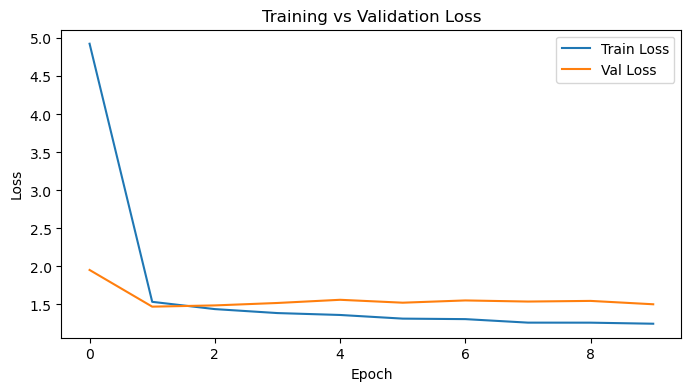

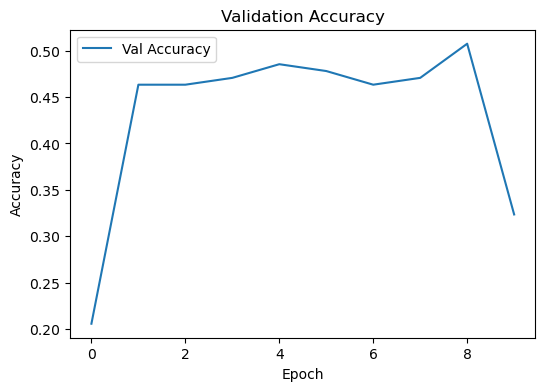

In [11]:
# === Block 4: Training setup and loop ===

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

EPOCHS = 10
train_losses, val_losses, val_accs = [], [], []

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
    
    scheduler.step()
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # ---- Validation ----
    model.eval()
    correct, total, val_loss = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    val_losses.append(val_loss / len(val_loader.dataset))
    val_accs.append(val_acc)

    print(f"Epoch [{epoch}/{EPOCHS}] - Train Loss: {epoch_loss:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.4f}")

# Save model
torch.save(model.state_dict(), "models/deep_model.pth")

# Plot training curves
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(val_accs, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.show()


✅ Test Accuracy: 0.3000



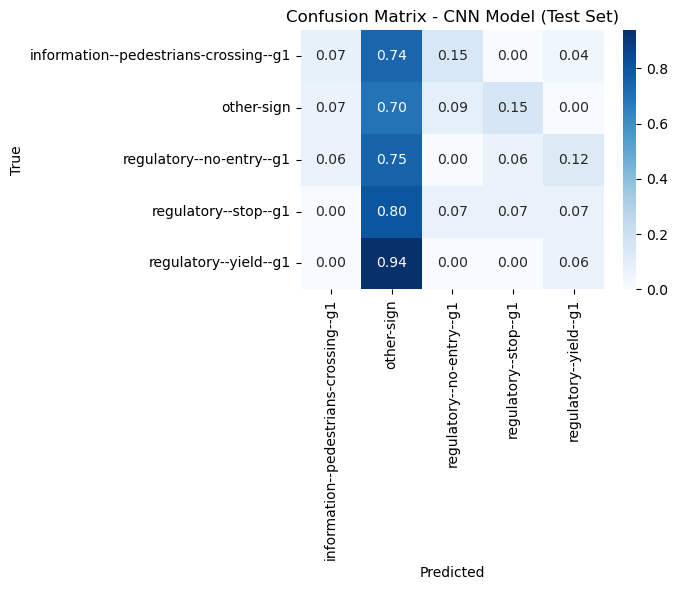

                                       precision    recall  f1-score   support

information--pedestrians-crossing--g1       0.33      0.07      0.12        27
                           other-sign       0.35      0.70      0.47        46
             regulatory--no-entry--g1       0.00      0.00      0.00        16
                 regulatory--stop--g1       0.11      0.07      0.08        15
                regulatory--yield--g1       0.20      0.06      0.10        16

                             accuracy                           0.30       120
                            macro avg       0.20      0.18      0.15       120
                         weighted avg       0.25      0.30      0.23       120



In [12]:
# === Block 5: Test Evaluation + Confusion Matrix ===
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns

model.eval()
all_labels, all_preds = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Metrics
acc = np.mean(np.array(all_labels) == np.array(all_preds))
print(f"✅ Test Accuracy: {acc:.4f}\n")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds, normalize="true")
labels_sorted = list(train_ds.label2name.values())

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=labels_sorted, yticklabels=labels_sorted)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - CNN Model (Test Set)")
plt.tight_layout()
plt.savefig("results/figures/confusion_matrix_cnn.png")
plt.show()

# Detailed report
print(classification_report(all_labels, all_preds, target_names=labels_sorted))
